In [1]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import sklearn
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler


import acquire
import env

In [2]:
# get the data and review the data

#fips is a unique identifier published by the usda.gov
#06037	Los Angeles	CA
#06059	Orange	CA
#06111	Ventura	CA

df0 = acquire.get_zillow_single_fam()

## datatypes look good with 2,152,863 records
print(df0.info(null_counts=True)) 
print("----------------------------")

## start the clean up
## remove cells with whitespace and replace with NaN in a new working dataframe

df = df0.replace(r'^\s*$', np.nan, regex=True)
df = df.rename(columns = {"bedroomcnt":"bedrooms",
                            "bathroomcnt":"bathrooms",
                            "calculatedfinishedsquarefeet":"area",
                            "taxvaluedollarcnt":"tax_value",
                            "taxamount":"taxes_yearly",
                            "yearbuilt":"year_built"
                            })


## drop n/a and review
print(df.isnull().sum(), "\n \t nulls prior to drop")
print("----------------------------")

df = df.dropna()

print(df.isnull().sum(), "\n \t nulls post drop")
print("----------------------------")


##ranges on these look very crazy, diving deeper
for col in df.columns:
    print("range of",col, ": {:,}".format((df[col].describe()["max"] - df[col].describe()["min"]).astype(int)), "({:,}".format(df[col].describe()["max"]), "max - min {:,})".format(df[col].describe()["min"]))

# 2,140,235 records
df.describe().T

/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_25060/538056523.py:11: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(df0.info(null_counts=True))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   bedroomcnt                    2152852 non-null  float64
 1   bathroomcnt                   2152852 non-null  float64
 2   calculatedfinishedsquarefeet  2144379 non-null  float64
 3   taxvaluedollarcnt             2152370 non-null  float64
 4   yearbuilt                     2143526 non-null  float64
 5   taxamount                     2148421 non-null  float64
 6   fips                          2152863 non-null  float64
dtypes: float64(7)
memory usage: 131.4 MB
None
----------------------------
bedrooms          11
bathrooms         11
area            8484
tax_value        493
year_built      9337
taxes_yearly    4442
fips               0
dtype: int64 
 	 nulls prior to drop
----------------------------
bedrooms        0
bathrooms       0
area          

,count,mean,std,min,25%,50%,75%,max
bedrooms,2140235.0,3.301419,0.932600,0.00,3.00,3.00,4.00,25.00
bathrooms,2140235.0,2.240352,0.990549,0.00,2.00,2.00,3.00,32.00
area,2140235.0,1863.193970,1221.754161,1.00,1258.00,1623.00,2208.00,952576.00
tax_value,2140235.0,460641.625164,677157.635675,22.00,189166.00,328296.00,534606.00,90188462.00
year_built,2140235.0,1960.967545,22.150563,1801.00,1949.00,1958.00,1976.00,2016.00
taxes_yearly,2140235.0,5616.711322,7814.562798,6.34,2540.85,4111.47,6411.93,1078101.87
fips,2140235.0,6048.309556,20.344910,6037.00,6037.00,6037.00,6059.00,6111.00


In [3]:
## def not looking correct. a single family house with 25 bedrooms? 32 bathrooms? almost a million sqft? 1mil in taxes a year?
## if looking for model to predict, i'm going to remove outliers that would skew data
## used tukey to remove outliers


## dropping <1 bathroom counts, since that's a code violation for a single family unit (requirement)
## also dropping <1 bedroom counts, since studios should not be considered a single family residence

## dropping any homes with less than 320sqft due to International Residential Code (IRC). 
## The IRC codes require that all homes must be built on a minimum of 320 square feet.


temp_list = ['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built', 'taxes_yearly']

tukey_k = 1.5

for col in temp_list:
       IQR = (df[col].describe()["75%"] - df[col].describe()["25%"])
       df = df[(df[col] < (df[col].describe()["50%"] + (IQR * tukey_k))) & \
            (df[col] > (df[col].describe()["50%"] - (IQR * tukey_k)))]


## using 3x STD from MEAN to determine retention
## using 3 sigma for deviation allowance to capture 99.7% (removing the extreme outliers)
#for col in temp_list:
#    df = df[(df[col] < (df[col].describe()["mean"] + df[col].describe()["std"]*3)) & \
#            (df[col] > (df[col].describe()["mean"] - df[col].describe()["std"]*3))]

#df = df[df.bathrooms>=1]
#df = df[df.bedrooms>=1]
#df = df[df.area>320]

df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,796639.0,3.208989,0.584149,2.00,3.00,3.00,4.000,4.0
bathrooms,796639.0,2.011141,0.153560,1.50,2.00,2.00,2.000,2.5
area,796639.0,1514.482786,289.681748,793.00,1289.00,1479.00,1704.000,2289.0
tax_value,796639.0,285074.071149,157258.255758,22.00,153581.00,272602.00,399081.500,696814.0
year_built,796639.0,1959.747951,10.419623,1934.00,1953.00,1958.00,1966.000,1984.0
taxes_yearly,796639.0,3532.074914,1762.016583,16.48,2098.58,3402.63,4841.375,7657.7
fips,796639.0,6050.318637,21.448517,6037.00,6037.00,6037.00,6059.000,6111.0


In [4]:

train, test = train_test_split( df, test_size= .2, random_state= 123)
train, validate = train_test_split( train, test_size= .25, random_state=123)

print(f"prepared df shape: {df.shape}")
print(f"train shape: {train.shape}")
print(f"validate shape: {validate.shape}")
print(f"test shape: {test.shape}")


prepared df shape: (796639, 7)
train shape: (477983, 7)
validate shape: (159328, 7)
test shape: (159328, 7)


In [5]:
X_train,X_validate = train[["taxes_yearly"]],validate[["taxes_yearly"]]
y_train,y_validate = train["tax_value"],validate["tax_value"]
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
no_scale = model.score(X_validate,y_validate)

# Apply the scalers we talked about in this lesson to your data and visualize the results for the unscaled and scaled distribution .

0.02266393854187588 no scale
0.022714149427595903


Text(0.5, 1.0, 'Scaled')

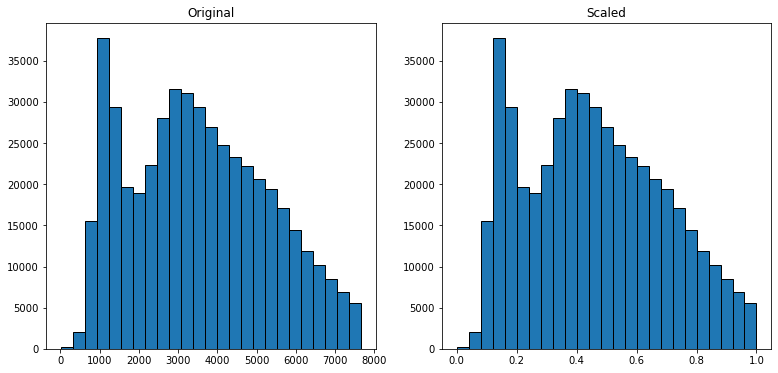

In [6]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_validate_scaled = scaler.transform(X_validate)

print(no_scale, "no scale")
model.fit(X_train_scaled,y_train)
print(model.score(X_validate_scaled,y_validate))

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')


0.02266393854187588 no scale
0.022714149427595903


Text(0.5, 1.0, 'Scaled')

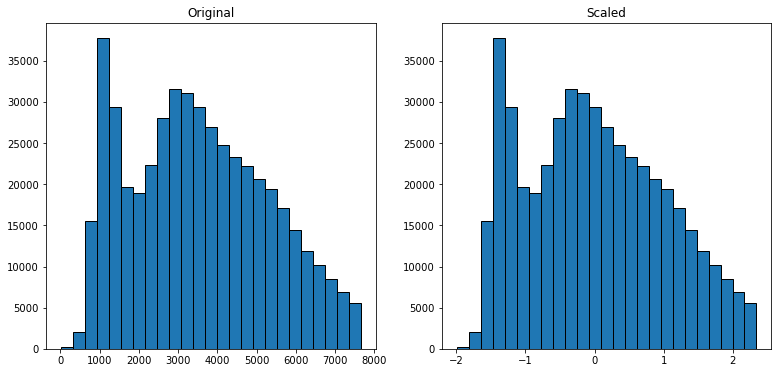

In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_validate_scaled = scaler.transform(X_validate)

print(no_scale, "no scale")
model.fit(X_train_scaled,y_train)
print(model.score(X_validate_scaled,y_validate))

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')

0.02266393854187588 no scale
0.022682767624020887


Text(0.5, 1.0, 'Scaled')

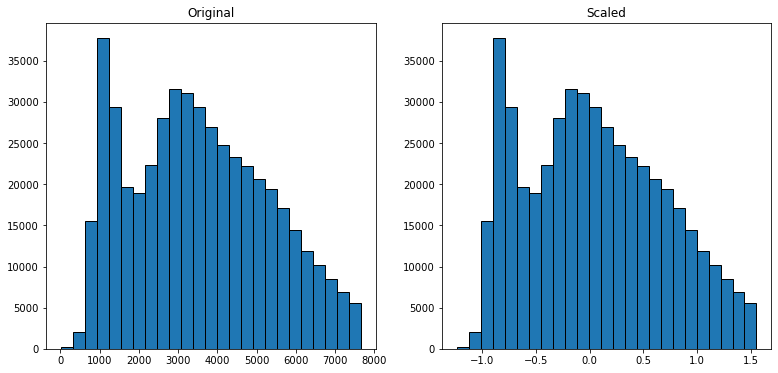

In [8]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_validate_scaled = scaler.transform(X_validate)

print(no_scale, "no scale")
model.fit(X_train_scaled,y_train)
print(model.score(X_validate_scaled,y_validate))

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')

# Apply the .inverse_transform method to your scaled data. Is the resulting dataset the exact same as the original data?

yes, looks like it

0.02266393854187588 no scale
0.022739254870455916


Text(0.5, 1.0, 'Scaled')

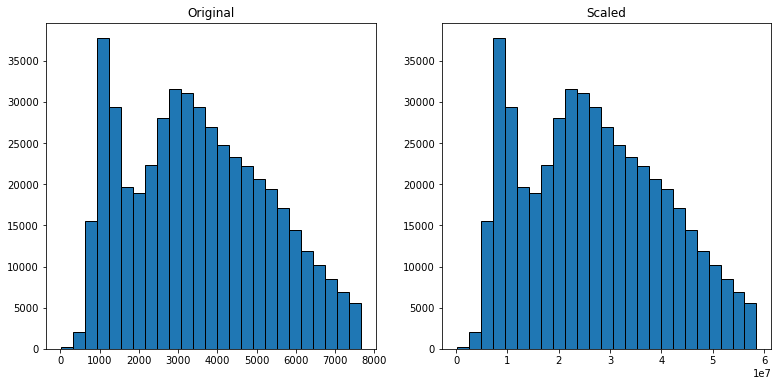

In [9]:
scaler = MinMaxScaler()

scaler.fit(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_train_scaled = scaler.inverse_transform(X_train)
X_validate_scaled = scaler.inverse_transform(X_validate)

print(no_scale, "no scale")
model.fit(X_train_scaled,y_train)
print(model.score(X_validate_scaled,y_validate))

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')


# Read the documentation for sklearn's QuantileTransformer. Use normal for the output_distribution and apply this scaler to your data. Visualize the result of your data scaling.


0.02266393854187588 no scale
0.022776913034745935


Text(0.5, 1.0, 'Scaled')

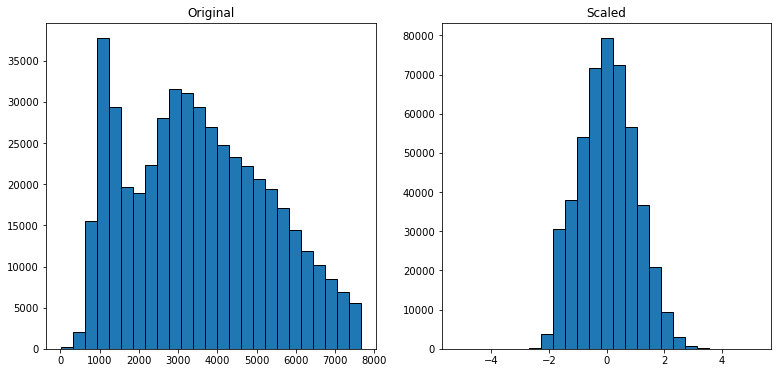

In [11]:

qt = sklearn.preprocessing.QuantileTransformer(n_quantiles=25,random_state=123,output_distribution="normal")

qt.fit(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_train_scaled = qt.transform(X_train)
X_validate_scaled = qt.transform(X_validate)

print(no_scale, "no scale")
model.fit(X_train_scaled,y_train)
print(model.score(X_validate_scaled,y_validate))

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')


# Use the QuantileTransformer, but omit the output_distribution argument. Visualize your results. What do you notice?

that it returned to the default arguement of uniform

0.02266393854187588 no scale
0.022714149427595903


Text(0.5, 1.0, 'Scaled')

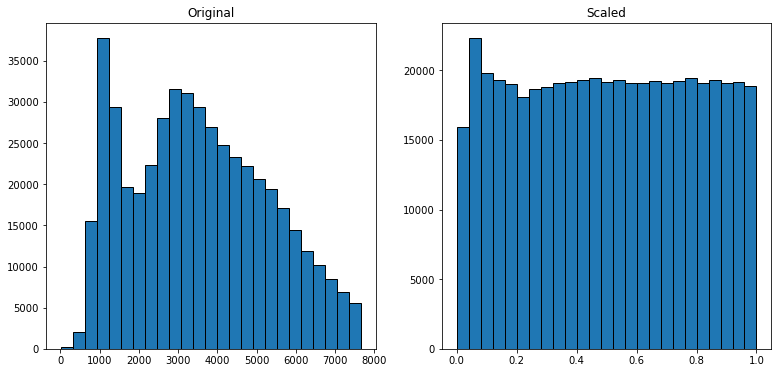

In [12]:

qt = sklearn.preprocessing.QuantileTransformer(n_quantiles=25,random_state=123)

qt.fit(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_train_scaled = qt.transform(X_train)
X_validate_scaled = qt.transform(X_validate)

print(no_scale, "no scale")
model.fit(X_train_scaled,y_train)
print(model.score(X_validate_scaled,y_validate))

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')


# Based on the work you've done, choose a scaling method for your dataset. Write a function within your prepare.py that accepts as input the train, validate, and test data splits, and returns the scaled versions of each. Be sure to only learn the parameters for scaling from your training data!

sure

-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-

## playing with the data


bin_df = pd.DataFrame()
df = df[df["tax_value"]<500_000]

for col in temp_list:
    bin_df[f"{col} binned"] = pd.cut(df[col],5)
bin_df["fips"] = df.fips
bin_df["dummy"] = 1
bin_df



binned = bin_df.groupby(bin_df.drop(columns=["dummy"]).columns.tolist()).sum().reset_index()
binned = binned[binned.dummy > 0]
binned



import plotly.express as px
import plotly

s_list = [ 'fips','tax_value binned']

all = binned["dummy"].sum()
#binned["percentage"] = (round(((binned["dummy"]/all)*100),3).astype(str) + "%")
binned["percentage"] = (binned["dummy"]/all)

fig = px.sunburst(  binned, 
                    path=s_list,
                    labels=s_list,
                    values='dummy',
                    color = "tax_value binned"
                    )
plotly.offline.plot(fig, validate=False)


